In [1]:
import cdpm
from cdpm import CondDirichletProcessMix
import numpy as np
from scipy import stats
from matplotlib import cm, pyplot as plt
import matplotlib as mpl
from bayesiankalman import mcmc
from tqdm import tqdm
import pandas as pd

In [2]:
%matplotlib inline
plt.style.use(['seaborn-dark-palette', 'seaborn-poster'])

In [3]:
np.random.seed(10234) # 10037

In [22]:
time_dim = 500
stick_scale = 1
beta_mu, beta_sigma = 0, 0.5 # mean and standard deviation
tau_df, tau_scale = 2, 1

In [23]:
cluster_series, alpha_series, beta_mat, precn_mat = cdpm.simulate_cdpm(time_dim=time_dim, beta_mu=beta_mu, 
                                                                       beta_sigma=beta_sigma, 
                                                                       stick_scale=stick_scale, precn_df=tau_df,
                                                                       precn_scale=tau_scale)

In [24]:
prior = {
    'comp': {
        'coeff': {'mean': [beta_mu], 'cov': [beta_sigma]},
        'precn': {'scale': [tau_scale], 'shape': [tau_df]}
    },
    'sticks': {
        'params': {
            'c': [stick_scale]
        }
    }
}

In [25]:
## Initialization
model = CondDirichletProcessMix(cluster_id=cluster_series[:-1], beta=beta_mat, tau=precn_mat, 
                                regressor=alpha_series[:-1].ravel(), regressand=alpha_series[1:].ravel())

In [26]:
model.coeffs

array([[[ 0.05483979]],

       [[ 0.0467492 ]],

       [[ 0.01661353]],

       [[ 0.1708784 ]],

       [[ 0.25306252]],

       [[ 0.15330464]],

       [[ 0.40998945]],

       [[-0.20482765]]])

## Estimation

In [27]:
num_draws = 3000

In [28]:
cluster_identity_draws = np.empty((num_draws, time_dim))
stick_draws = np.full((num_draws, 30),np.nan)
beta_draws = np.full((num_draws, 30),np.nan)
precision_draws = np.full((num_draws, 30),np.nan)

In [29]:
for draw_idx in tqdm(range(num_draws)):
    model_posterior = model(prior)
    cluster_identity_draws[draw_idx] = model_posterior[0]
    stick_draws[draw_idx,:len(model_posterior[1])] = model_posterior[1]
    beta_draws[draw_idx,:len(model_posterior[2])] = np.squeeze(model_posterior[2]) 
    precision_draws[draw_idx,:len(model_posterior[3])] = model_posterior[3]
    

100%|██████████| 3000/3000 [00:07<00:00, 406.65it/s]


## Simulation Results

In [30]:
percentiles = np.linspace(1,99, 25).round()

In [31]:
state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)

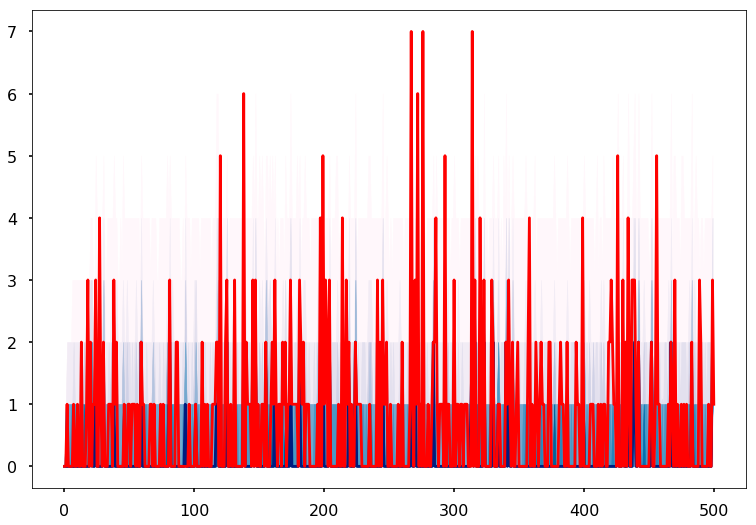

In [32]:
state_comparison_fig, state_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(state_comparison_ax, pd.DataFrame(cluster_identity_draws.T), percentiles, cm=cm.get_cmap('PuBu'))
state_comparison_ax.plot(cluster_series, c='red')

In [33]:
pd.DataFrame(beta_draws).mean().dropna()

0     0.032059
1     0.069569
2     0.052997
3     0.015940
4    -0.015157
5     0.001571
6    -0.007711
7     0.027604
8     0.026571
9    -0.050615
10    0.218225
11   -0.672924
dtype: float64

In [34]:
beta_mat

array([ 0.05483979,  0.0467492 ,  0.01661353,  0.1708784 ,  0.25306252,
        0.15330464,  0.40998945, -0.20482765])

In [35]:
pd.DataFrame(stick_draws).mean().dropna()

0     0.733141
1     0.633784
2     0.614433
3     0.592582
4     0.532146
5     0.552993
6     0.537413
7     0.546888
8     0.491969
9     0.436379
10    0.306887
11    0.890996
dtype: float64

In [36]:
pd.DataFrame(precision_draws).mean().dropna()

0     3.920777
1     2.100903
2     1.460489
3     1.754466
4     1.876561
5     1.868636
6     1.929512
7     1.991031
8     2.213962
9     2.006453
10    2.351854
11    0.665491
dtype: float64

In [37]:
precn_mat

array([ 3.95695327,  5.51753473,  1.15736289,  0.25611656,  1.51751121,
        0.25556572,  0.3311921 ,  0.54771316])